# Generating an n-gram network of the complete (canonical) human proteome

For this analysis a complete set of the human proteome is being imported and all domain architectures will undergo n-gram analysis. The proteome is limited to only the canonical forms of genes.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import ngramUtilities
import matplotlib.pyplot as plt
from os import listdir
from matplotlib import cm,colors
import generateCompleteProteome
import entropyCalc
import ngramNets

In [ ]:
# This is for if the adjacency matrix had been previously generated from either another notebook or in this notebook to cut down on runtime.
adj_comp = generateCompleteProteome.generate_adjacency_json('Current_Adjacency.json', adj_dir='./')
rm_ngrams = generateCompleteProteome.import_removed_ngrams('Current_Complete_Proteome_Removed_Ngrams.csv',rm_dir='./')
ref_df, interpro_dict = generateCompleteProteome.import_proteome_files()

Generating a new Adjacency Matrix but not a csv file.


In [27]:
# Importing and getting the complete proteome information
ref_df, interpro_dict = generateCompleteProteome.import_proteome_files()
full_model = ngramNets.dansy(ref=ref_df, n =67,interproIDs=[k for k in interpro_dict],collapse = True)
adj_comp = full_model.adj
rm_ngrams = full_model.collapsed_ngrams

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


In [28]:
_,full_ngram_dict = ngramUtilities.get_ngrams_from_df(ref_df,[k for k in interpro_dict.keys()],66)

In [29]:
all_IDs = [x for x in interpro_dict.keys()]
orig_ref = ref_df.copy()
ngram_models = {}
ngram_check = {}

In [ ]:
# For a select number of n-gram models also generating the adjacency for plotting.
ngram_model_adjs = {}
mods_OI = [2,5,10,15]
for i in mods_OI:
    m = ngramNets.dansy(ref=ref_df, n=i, interproIDs=all_IDs)
    ngram_model_adjs[f'{i}-gram Model'] = {'Adjacency':m.adj, 'Removed Ngrams':m.collapsed_ngrams}

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


In [5]:
# Getting the maximum length of n-grams in the complete proteome
max_len = max([len(x.split('|')) for x in ref_df['Interpro Domain Architecture IDs'].tolist()])

In [6]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01


In [7]:
# The maximum length for domain architectures is from the protein Tintin (Uniprot ID: Q8WZ42) that has >300 domains which is a bit too much for entropy calculations. As a result determining the second largest length.
ttn_idx = ref_df[ref_df['UniProt ID'] == 'Q8WZ42'].index
temp_ref = ref_df.drop(ttn_idx, axis = 0 )
max_len = max([len(x.split('|')) for x in temp_ref['Interpro Domain Architecture IDs'].tolist()])

In [8]:
max_len

66

In [9]:
entropies = {}

In [10]:
# Determining the entropy for the full n-gram model
all_archs = ref_df['Interpro Domain Architecture IDs'].tolist()
ngram_list = adj_comp.columns.tolist()
entropies['F0'] = entropyCalc.calc_F0(ngram_list)
entropies['F1'] = entropyCalc.calc_F1(all_archs)

for m in range(2, 16):
    entropies[f'F{m}'] = entropyCalc.calc_FN_from_adjacency(adj_comp, all_archs, m, rm_ngrams,db_check=1)
    
entropies[f'F{max_len}'] = entropyCalc.calc_FN_from_adjacency(adj_comp, all_archs, max_len, rm_ngrams,db_check=1)
ngram_models['Full Model'] = {}
ngram_models['Full Model']['Entropy Values'] = entropies

In [11]:
import seaborn as sns


In [12]:
# Adding in the last entroy value that is non-zero and the one associated with the maximal length
tst = np.nonzero([v for v in entropies.values()])
f_max = np.max(tst)

In [13]:
entropy_comp = pd.DataFrame(index=ngram_models.keys(), columns=[f'F{n}' for n in range(0,15+1)]+[f'F{max_len}'],dtype=float)
f1_info_gain = pd.DataFrame(index=ngram_models.keys(), columns=[f'F{n}' for n in range(2,15+1)]+[f'F{max_len}'], dtype=float)


In [14]:
# Getting the complete information gain of the full model over the course of the entire n-gram length
x2 = []
entropy_OI = ngram_models['Full Model']['Entropy Values']
f1 = entropy_OI['F1']

for entropy in entropy_OI:
    
    H = entropy_OI[entropy]
    if entropy not in ['F0','F1']:
        H_w = f1 - H
        x2.append(H_w)

In [15]:
x2[13]

np.float64(4.991262310104515)

Text(0, 0.5, 'Relative Informatin Gain')

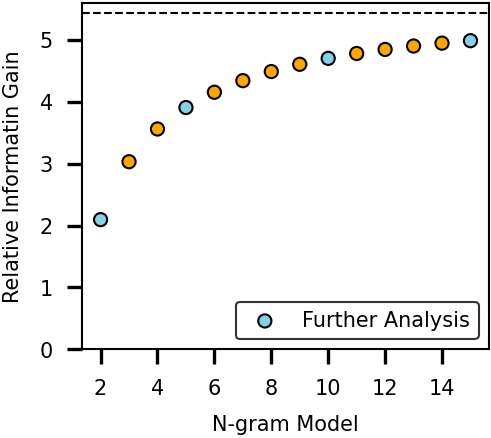

In [ ]:
# Generating the colors to emphasize the models that will be compared
plot_cols =[]
for m in range(2,len(x2)+1):
    if m in mods_OI:
        plot_cols.append('skyblue')
    else:
        plot_cols.append('orange')

plt.figure(figsize=(1.75,1.5),dpi = 300)
plt.scatter(range(2,len(x2)+1),x2[:-1], c=plot_cols,s = 10,edgecolors='k', linewidths=0.5)
plt.axhline(y = x2[-1],color='k', linestyle = 'dashed', linewidth = 0.5)
l = plt.legend(['Further Analysis'], loc = 'lower right',fontsize=5, frameon=True, edgecolor = 'k')
l.get_frame().set_linewidth(0.5)
plt.xlabel('N-gram Model')
a=plt.gca()
a.set_xticks(np.arange(2,16,2))
a.set_yticks(np.linspace(0,5,6))
plt.ylabel('Relative Informatin Gain')
plt.savefig('Figures/Manuscript Figures/Figure 2 Ngram Model Comparison/Focused Information Gain.svg')

In [17]:
proteome_arch_len = [len(str(x).split('|')) if x != '' else 0 for x in ref_df['Interpro Domain Architecture IDs'].tolist()]

### Generating the baseline network of the complete proteome.

In [30]:
G = full_model.G

In [ ]:
pos = nx.spring_layout(G, seed = 882)

### For a select number of n-gram models also generating the networks for a simple comparison based on number of connected components and isolates

In [21]:
Gs_comps = {}
for mod in ngram_model_adjs:
    G_mod = nx.from_pandas_adjacency(ngram_model_adjs[mod]['Adjacency'])
    pos_mod = nx.spring_layout(G_mod)
    Gs_comps[mod] = {'Graph':G_mod, 'Position':pos_mod}

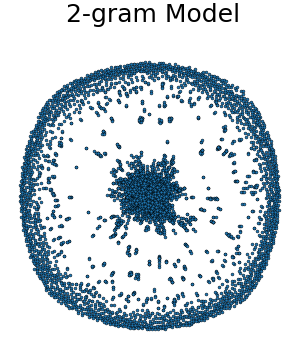

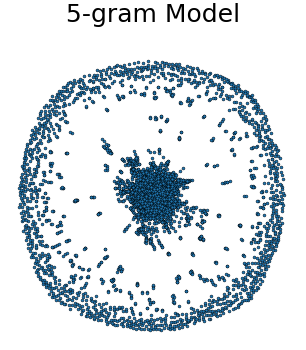

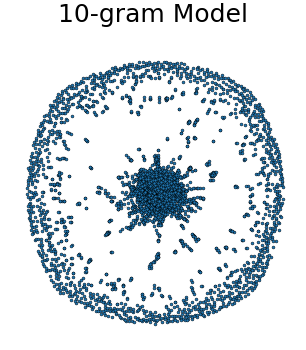

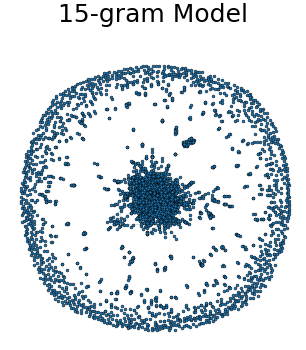

In [32]:
ngram_net_gross_top = pd.DataFrame(columns=['Isolates', 'Connected Components','Articulation Points'], index=[k for k in Gs_comps.keys()]+['Full Model'])
for G_oi in Gs_comps:
    G_temp = Gs_comps[G_oi]['Graph']
    G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
    pos_temp = Gs_comps[G_oi]['Position']
    plt.figure(figsize=(1,1),dpi = 300, clear=True)
    nx.draw(G_temp, pos=pos_temp, 
        node_size = 0.5, edgecolors= 'k',
        edge_color = '#808080', width = 0.05, linewidths = 0.1)
    plt.title(G_oi)
    ngram_net_gross_top.loc[G_oi,'Isolates'] = nx.number_of_isolates(G_temp)
    ngram_net_gross_top.loc[G_oi,'Connected Components'] = nx.number_connected_components(G_temp)
    ngram_net_gross_top.loc[G_oi,'Articulation Points'] = len(list(nx.articulation_points(G_temp)))
    #plt.savefig(f'Figures/Manuscript Figures/Figure 1 Full Proteome Characterization/{G_oi} Network.png')  
    # Getting gross network topology measurements

ngram_net_gross_top.loc['Full Model','Isolates'] = nx.number_of_isolates(G)
ngram_net_gross_top.loc['Full Model','Connected Components'] = nx.number_connected_components(G)
ngram_net_gross_top.loc['Full Model','Articulation Points'] = len(list(nx.articulation_points(G)))

## Continuing characterization of the 3 different n-gram models by comparing how the connected components and isolates have changed across them.

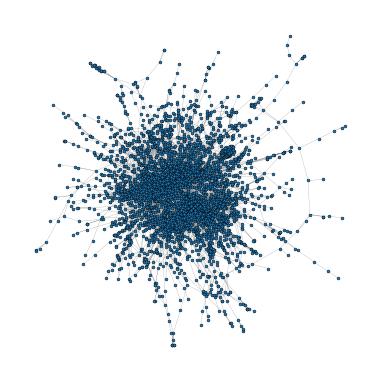

In [ ]:
# Plotting a subgraph of the Full Model to show what the largest connected component looks like
large_cc = max(nx.connected_components(G), key=len)
plt.figure(figsize=(1.25,1.25),dpi = 300, clear=True)
nx.draw(G.subgraph(large_cc), pos=pos, 
        node_size = 0.5, edgecolors= 'k',
        edge_color = '#808080', width = 0.05, linewidths = 0.1)
plt.savefig('Figures/Manuscript Figures/Figure 1 Full Proteome Characterization/Largest Connected Component.svg', dpi = 300)

In [33]:
mod_freq_dicts = {}
basic_cc_comps = pd.DataFrame(columns=['Isolates','Isolates Generated','Truncated','Split','Preserved'], index=Gs_comps.keys())
for mod in Gs_comps:
    x = len(set(nx.isolates(G)).intersection(nx.isolates(Gs_comps[mod]['Graph'])))
    p = entropyCalc.build_freq_dict_from_adj(ngram_model_adjs[mod]['Adjacency'], ref_df['Interpro Domain Architecture IDs'],ngram_model_adjs[mod]['Removed Ngrams'])
    mod_freq_dicts[mod] = p
    basic_cc_comps.loc[mod, 'Isolates'] = x
    basic_cc_comps.loc[mod, 'Isolates Generated'] = nx.number_of_isolates(Gs_comps[mod]['Graph'])-x
    cc_num = 0 #Completely overlapping ccs
    cn2 = 0 # Truncated ccs
    spl_cnt = 0 # Split ccs
    for cc1 in nx.connected_components(G):
        if len(cc1) == 1: # Skip isolates
            continue
        found_flag = 0
        split_flag = 0


        for cc2 in nx.connected_components(Gs_comps[mod]['Graph']):
            
            # Complete overlap
            if cc1.difference(cc2) == set():
                cc_num += 1
                found_flag = 1

            

            # Partial overlap
            elif len(cc1.difference(cc2)) < len(cc1):
                if found_flag == 1 and split_flag == 0:
                    # If members were previously found then saying it was split
                    spl_cnt += 1
                    cn2 -= 1
                    split_flag = 1
                elif split_flag == 0:    
                    cn2 += 1
                
                found_flag = 1
    
    basic_cc_comps.loc[mod, 'Truncated'] = cn2
    basic_cc_comps.loc[mod, 'Split'] = spl_cnt
    basic_cc_comps.loc[mod, 'Preserved'] = cc_num


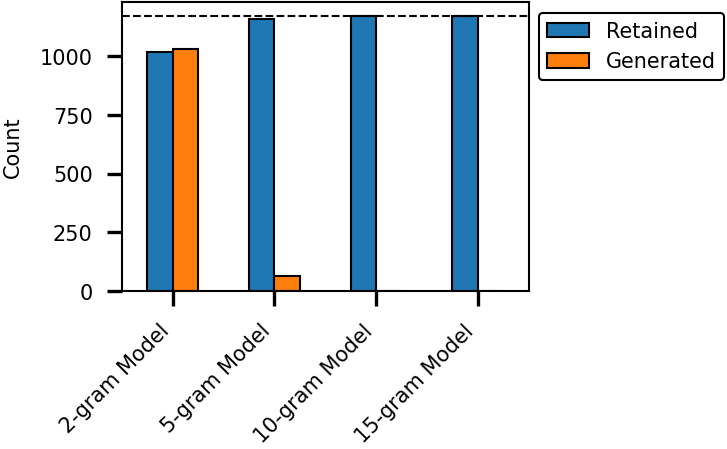

In [ ]:

basic_cc_comps.filter(['Isolates','Isolates Generated'],axis=1).plot.bar(edgecolor ='k',linewidth=0.5)
f =plt.gcf()
f.set_size_inches((1.75,1.25))
f.set_dpi(300)
plt.ylabel('Count')

l = plt.legend(edgecolor='k',framealpha=1, labels=['Retained', 'Generated'],bbox_to_anchor=(1,1))
l.get_frame().set_linewidth(0.5)
l.get_frame().set_edgecolor('k')
plt.xticks(rotation=45,ha='right')
plt.axhline(nx.number_of_isolates(G), color = 'k', linewidth=0.5, linestyle='dashed')

plt.savefig('Figures/Manuscript Figures/Figure 2 Ngram Model Comparison/Isolate Retrieval.svg', transparent=True)

In [40]:
basic_cc_comps

,Isolates,Isolates Generated,Truncated,Split,Preserved
2-gram Model,1017,1030,98,18,141
5-gram Model,1158,64,12,2,247
10-gram Model,1170,2,3,0,258
15-gram Model,1171,1,2,0,259


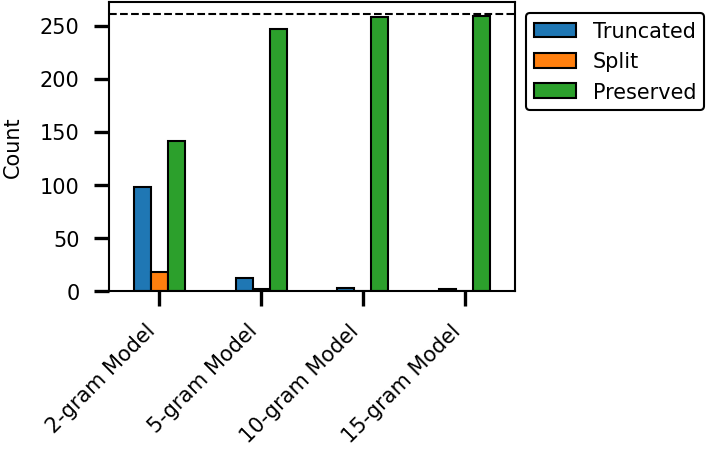

In [ ]:

basic_cc_comps.drop(['Isolates','Isolates Generated'],axis=1).plot.bar(edgecolor ='k',linewidth=0.5,stacked=False)
f =plt.gcf()
f.set_size_inches((1.75,1.25))
f.set_dpi(300)
plt.ylabel('Count')

l = plt.legend(edgecolor='k',framealpha=1, bbox_to_anchor=(1,1))
l.get_frame().set_linewidth(0.5)
l.get_frame().set_edgecolor('k')
plt.xticks(rotation=45,ha='right')
plt.axhline(nx.number_connected_components(G)-nx.number_of_isolates(G), color = 'k', linewidth=0.5, linestyle='dashed')

plt.savefig('Figures/Manuscript Figures/Figure 2 Ngram Model Comparison/Non-Isolate Retrieval.svg', transparent=True)

In [37]:
# For each of the ngram models now checking how the relative entorpy changes
q = entropyCalc.build_freq_dict_from_adj(adj_comp,ref_df['Interpro Domain Architecture IDs'],rm_ngrams)

In [38]:
kl_df = pd.DataFrame(index=mod_freq_dicts.keys(),columns=['Relative Entropy'])
for mod,p in mod_freq_dicts.items():
    
    kl = entropyCalc.relativeEntropy(p,q)
    kl_df.loc[mod, 'Relative Entropy'] = kl

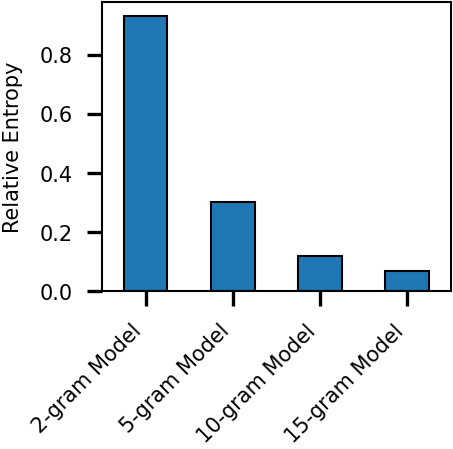

In [ ]:
kl_df.plot.bar(edgecolor = 'k',linewidth = 0.5)
f = plt.gcf()
f.set_size_inches((1.5,1.25))
f.set_dpi(300)
plt.ylabel('Relative Entropy')
plt.xticks(rotation = 45,ha='right')
plt.legend().remove()
plt.savefig('Figures/Manuscript Figures/Figure 2 Ngram Model Comparison/Relative Entropy.svg', transparent=True)